In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import seaborn as sns
from gerrychain import Graph, GeographicPartition, Partition, Election, accept
from gerrychain.updaters import Tally, cut_edges
import glob
import functools
import operator

In [2]:
def foldl(func, acc, xs):
  return functools.reduce(func, xs, acc)

foldr = lambda func, acc, xs: functools.reduce(lambda x, y: func(y, x), xs[::-1], acc)

In [3]:
# Get maximum number of districts for different VAP with different threshholds
def get_max_maj_pop_dists(maj, pop_col, threshes=['30.0%', '35.0%', '40.0%', '45.0%', '50.0%']):
    for thresh in threshes:
        max_dist = 0
        for i in range(10):
            if thresh == '50.0%' and pop_col == 'BVAP':
                np_sb = np.load(f"./data/states/NC_dists14_{pop_col}opt_4.5%_100000_sbl50_th{thresh}_score0_{i}.npy")
                max_dist = np_sb[-1].max()
            else:
                np_sb = np.load(f"./data/states/NC_dists14_{pop_col}opt_4.5%_5000_sbl50_th{thresh}_score0_{i}.npy")
                max_dist = np_sb[-1].max()
        maj[thresh] = max_dist

maj_bvap = {}
get_max_maj_pop_dists(maj_bvap, 'BVAP')
print(maj_bvap)

{'30.0%': 5.0, '35.0%': 2.0, '40.0%': 1.0, '45.0%': 0.0, '50.0%': 0.0}


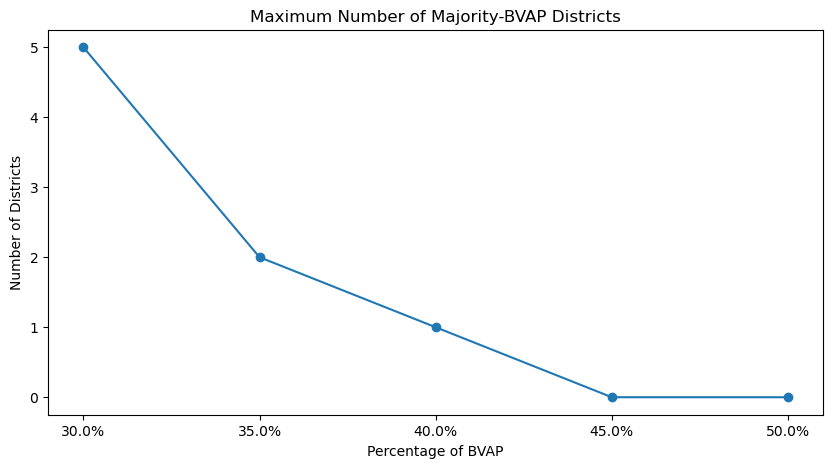

In [4]:
x = list(maj_bvap.keys())
y = list(maj_bvap.values())

plt.figure(figsize=(10, 5))
plt.plot(x, y, marker='o')  # 'o' for circle markers
plt.title('Maximum Number of Majority-BVAP Districts')
plt.xlabel('Percentage of BVAP')
plt.ylabel('Number of Districts')
plt.show()

In [5]:
maj_nwvap = {}
get_max_maj_pop_dists(maj_nwvap, 'nWVAP', ['40.0%', '50.0%'])
print(maj_nwvap)

{'40.0%': 9.0, '50.0%': 3.0}


In [6]:
ubs = glob.glob("./data/unbiased/NC_dists14_4.5%_100000_unbiased_*.p")
ub_runs = {}
for i, run in enumerate(ubs):
     with open(run, "rb") as f:
        ub_runs[i] = pickle.load(f)

In [7]:
runs = list(ub_runs.values())
bvap = foldl(lambda x,y: np.concatenate((x,y["BVAP"]), axis=0), runs[0]["BVAP"], runs[1:])
wvap = foldl(lambda x,y: np.concatenate((x,y["WVAP"]), axis=0), runs[0]["WVAP"], runs[1:])

In [8]:
nwvap = np.sort(1 - wvap)
nwvap

array([[0.15337247, 0.21499392, 0.24286428, ..., 0.45311109, 0.49928559,
        0.5627198 ],
       [0.15337247, 0.21499392, 0.24286428, ..., 0.45311109, 0.49928559,
        0.5627198 ],
       [0.15337247, 0.21499392, 0.24286428, ..., 0.45311109, 0.50411641,
        0.5627198 ],
       ...,
       [0.16307756, 0.17768734, 0.26380607, ..., 0.4449942 , 0.4837476 ,
        0.54496958],
       [0.16307756, 0.17768734, 0.24711387, ..., 0.44659844, 0.4837476 ,
        0.54496958],
       [0.16307756, 0.17768734, 0.26856818, ..., 0.4449942 , 0.4837476 ,
        0.54496958]])

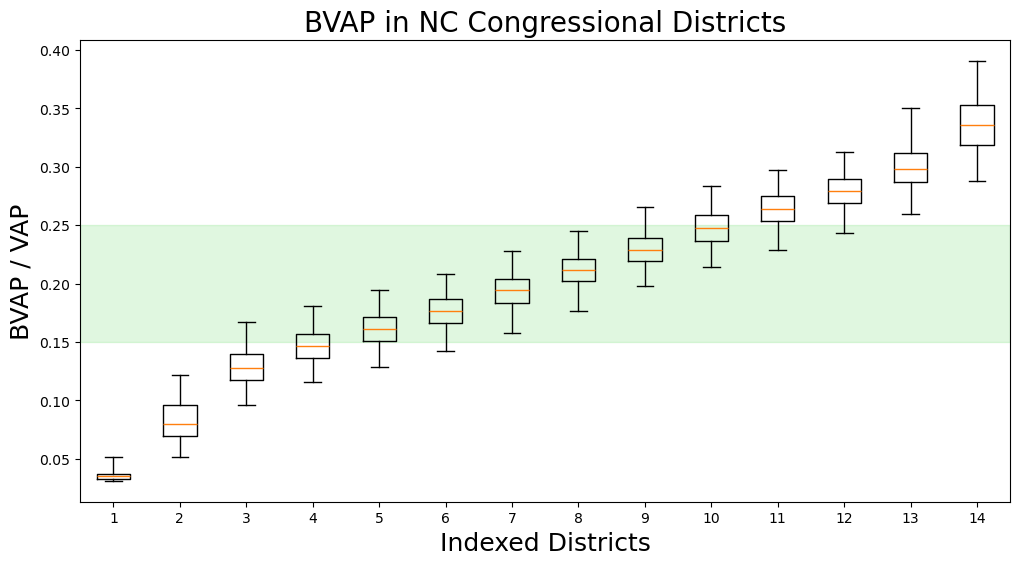

In [9]:
plt.figure(figsize=(12,6))
plt.boxplot(bvap[:,:], whis=(1,99), showfliers=False)
plt.axhspan(0.15, 0.25, color="limegreen", alpha=0.15, zorder=0)
plt.title("BVAP in NC Congressional Districts", fontsize=20)
plt.xlabel("Indexed Districts", fontsize=18)
plt.ylabel("BVAP / VAP", fontsize=18)
plt.savefig("./plots/unbiased_bvap_boxplot.png", dpi=200, bbox_inches='tight')
plt.show()

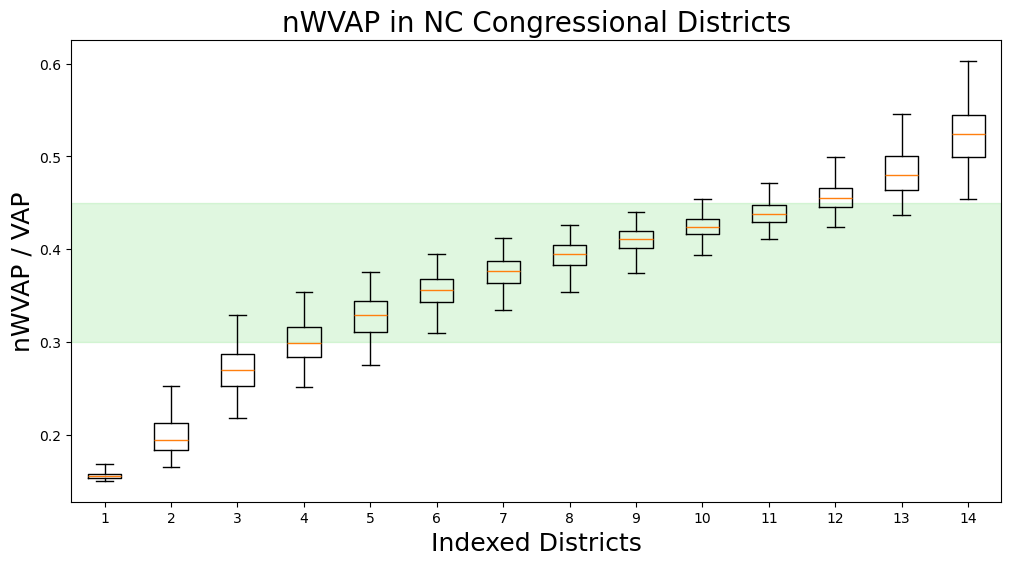

In [10]:
plt.figure(figsize=(12,6))
plt.boxplot(nwvap[:,:], whis=(1,99), showfliers=False)
plt.axhspan(0.3, 0.45, color="limegreen", alpha=0.15, zorder=0)
plt.title("nWVAP in NC Congressional Districts", fontsize=20)
plt.xlabel("Indexed Districts", fontsize=18)
plt.ylabel("nWVAP / VAP", fontsize=18)
plt.savefig("./plots/unbiased_nwvap_boxplot.png", dpi=200, bbox_inches='tight')
plt.show()